In [78]:
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [79]:
interpreter = tf.lite.Interpreter(model_path = "/Users/simon/Desktop/Projects/pose detection/lite-model_movenet_singlepose_lightning_tflite_float16_4.tflite")
interpreter.allocate_tensors()

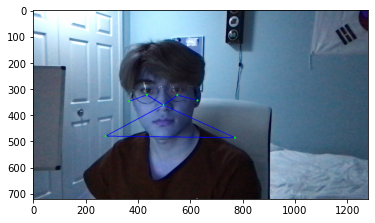

In [80]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()
    
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192, 192)
    input_image = tf.cast(img, dtype=tf.uint8)
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)
    
    cv2.imshow("MoveNet Lightning", frame)
    
    if cv2.waitKey(1) == ord('q'):
        break

plt.imshow(frame.copy())
cap.release()
cv2.destroyAllWindows()

In [81]:
right_eye = keypoints_with_scores[0][0][2]
left_elbow = keypoints_with_scores[0][0][7]

In [82]:
shaped = np.squeeze(np.multiply(interpreter.get_tensor(interpreter.get_output_details()[0]['index']),[480, 640, 1]))

In [83]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [84]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1)

In [85]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)